## Домашнее задание
В рамках домашнего задания вам нужно применить Q-learning для решения задачи `CartPole-v0`.<br>
К тому, что мы уже написали, нужно будет добавить:<br>
* дискретизацию описания состояния
* добавить к стратегии exploration

hint: параметры exploration (epsilon или tau), а также скорость обучения alpha можно менять во время обучения.

Максимум  за задание **8 баллов** <br>
**3 балла** за корректную реализацию exploration и дискретизацию и работающее применение <br>
**+2 балла** если получится достигнуть работы агента, при которой скользящее среднее по 100 эпизодам не падает ниже 100 <br>
**+3 балла** если получится достигнуть скользящего среднего по 100 эпизодам 1000 и выше <br>
(результат должен быть воспроизводим)

Получилось ли добиться стабильного результата работы агента? Как думаете, почему?  


1 компонента - горизонтальная координата<br>
2 компонента - горизонтальная скорость<br>
3 компонента - угол наклона<br>
4 компонента - угловая скорость<br>

Описание среды можно посмотреть тут:<br>
https://gym.openai.com/envs/CartPole-v0/ <br>
https://github.com/openai/gym/wiki/CartPole-v0

### Решение

#### Импортируем библиотеки и определяем функцию скользящего среднего

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt 
from time import sleep
from IPython.display import clear_output
import pandas as pd
import math
import pandas as pd

#Скользящее среднее
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    result = np.concatenate([ret[:n-1] / (np.arange(n-1) + 1)  , ret[n-1:] / n])
    return result

In [2]:
env = gym.make('CartPole-v0').env

In [3]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [4]:
env.reset()

array([-3.51771714e-02,  9.35057747e-05,  4.07205920e-02, -2.21303508e-02])

In [5]:
env.observation_space.low, env.observation_space.high

(array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32))

In [6]:
state, reward, done, info = env.step(env.action_space.sample())
state, reward, done, info

(array([-0.0351753 , -0.19558804,  0.04027799,  0.2831172 ]), 1.0, False, {})

In [7]:
env.action_space.sample()

1

In [8]:
# Посмотрим, какие наиболее вероятные значения получаем в env.observation_space.high[0]
# и env.observation_space.high[2] (Это справедливо, ведь мы можем сделать такую оценку, зная систему)
# Это нужно для задания бакетов
res = 0
experiment_1 = []
experiment_3 = []
for res in range(200):
    experiment = env.reset()
    experiment_1.append(experiment[1])
    experiment_3.append(experiment[3])
    print(experiment[1], experiment[3])

-0.02101321388155102 0.029039183484285108
-0.04901663957340823 -0.0015206539071065048
0.04821687995011302 0.005067933811566963
-0.020909972570227878 -0.032336288643521824
-0.044331290964254935 -0.020130500470880608
0.006708753393846557 0.01952451571394906
-0.011515961107605874 0.0039016713907496087
-0.006387020206900497 0.03872922497988715
0.015647627558950564 0.03917895906815705
-0.04150791616973476 -0.00675509373259716
0.028022249185065393 0.0007744709246036013
-0.017570974533188587 -0.016331932163585597
-0.012026938749779378 -0.027553496935180957
-0.04809760110452296 -0.006290549391235113
0.03535990896199778 0.011405197429101309
0.0249130037047936 -0.04570198104846327
-0.019931503099667125 -0.021185979252554867
-0.023594209185836802 -0.018879109113559413
0.0261572000427113 -0.03125784142513978
0.04766797445229955 -0.03313462906590242
0.006952966290274996 0.00750338484947817
0.022284896239182783 0.03637290345740868
0.002972060316348099 0.02672304575155278
0.010838739484599715 0.04918

In [9]:
print(min(experiment_1), max(experiment_1))

-0.04956549062768201 0.04994933280632023


In [10]:
print(min(experiment_3), max(experiment_3))

-0.049813281277233015 0.049742812598658814


### Подход для среднего 100
- Дискретизация по бакетам каждой из 4 непрерывных переменных
- Exploration

In [11]:
env.observation_space.high[3]

3.4028235e+38

In [12]:
#Найдем границы значений 4 переменных
#1 и 3 могу принимать значения в большем диапазоне, сделаем макс и мин на свое усмотрение,
#остальное помещаем в отдельный бакет
up = [env.observation_space.high[0], 0.4, env.observation_space.high[2], 0.7]
low = [env.observation_space.low[0], -0.4, env.observation_space.low[2], -0.7]

In [13]:
up

[4.8, 0.4, 0.41887903, 0.7]

In [14]:
low

[-4.8, -0.4, -0.41887903, -0.7]

In [15]:
buckets = (6, 6, 8, 12,)
episodes = 30000 + 1
min_alpha = 0.1
min_eps = 0.1
gamma = 1.0
Q = np.zeros(buckets + (env.action_space.n,))
rewards_log = []

In [16]:
for episode in range(1,episodes):
    
    done = False
    total_reward = 0
    
    #Дискретизация----
    state = env.reset()
    proportion = []
    bucket_state = []
    for i in range(len(state)):
        proportion.append((state[i] + abs(low[i])) / (up[i] - low[i])) #доля данного значения в общем
        bucket_state.append(int(round((buckets[i] - 1) * proportion[i])))
    state = tuple([min(buckets[i] - 1, max(0, bucket_state[i])) for i in range(len(state))])
    #-----------------
    
    alpha = min_alpha
    eps = min_eps
    
    while done != True:
        
        # Выбираем действие с exploration
        if (np.random.random() <= eps):
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])
        
        # делаем шаг
        state2, reward, done, info = env.step(action)
        
        #Дискретизация----
        proportion2 = []
        bucket_state2 = []
        for i in range(len(state2)):
            proportion2.append((state2[i] + abs(low[i])) / (up[i] - low[i])) #доля данного значения в общем
            bucket_state2.append(int(round((buckets[i] - 1) * proportion2[i])))
        state2 = tuple([min(buckets[i] - 1, max(0, bucket_state2[i])) for i in range(len(state2))])
        #-----------------
        
        # дообучаем Q-значение
        if not done:
            Q[state][action] += alpha * (reward + gamma * np.max(Q[state2]) - Q[state][action])
        else:
            Q[state][action] += alpha * (reward - Q[state][action])
            
        total_reward += reward
        total_reward = int(total_reward)
        state = state2
        
    if episode % 1000 == 0 or episode == 1:
        print(f'Episode {episode:4d}  Total Reward: {total_reward:4d}')
    rewards_log.append(total_reward)

Episode    1  Total Reward:   14
Episode 1000  Total Reward:   26
Episode 2000  Total Reward:   25
Episode 3000  Total Reward:   38
Episode 4000  Total Reward:   34
Episode 5000  Total Reward:  120
Episode 6000  Total Reward:  768
Episode 7000  Total Reward:  655
Episode 8000  Total Reward:  285
Episode 9000  Total Reward:  210
Episode 10000  Total Reward:  198
Episode 11000  Total Reward:  337
Episode 12000  Total Reward:   79
Episode 13000  Total Reward:  146
Episode 14000  Total Reward:  195
Episode 15000  Total Reward:  423
Episode 16000  Total Reward:  172
Episode 17000  Total Reward:  268
Episode 18000  Total Reward:  188
Episode 19000  Total Reward:  393
Episode 20000  Total Reward:  711
Episode 21000  Total Reward:  785
Episode 22000  Total Reward:  727
Episode 23000  Total Reward:  491
Episode 24000  Total Reward:  287
Episode 25000  Total Reward:  511
Episode 26000  Total Reward:  143
Episode 27000  Total Reward:  134
Episode 28000  Total Reward:  731
Episode 29000  Total Rew

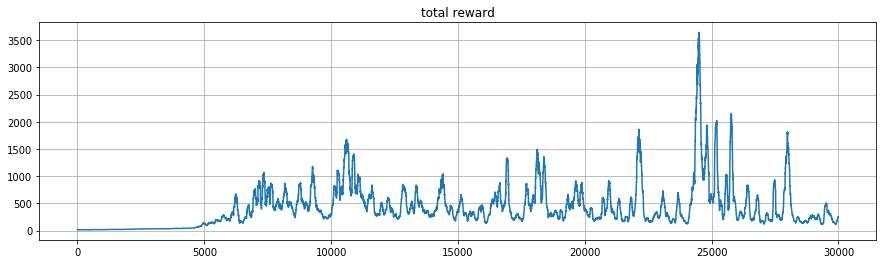

In [17]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.plot(moving_average(rewards_log))
axs.set_title('total reward')
plt.grid(True)
plt.show()

In [18]:
min(moving_average(rewards_log)[10000:])

116.64

### Вывод

- Стабильного по скользящему среднему добиться удалось,
- если считать стабильным превышение некого значения (100, 200)


- В более общем понимании стабильности , то есть отсутствия скачков,
- добиться не удалось
- Нужно лучше подбирать параметры


- Возможно, это связано с дискретизацией, так как мы все равно теряем таким образом некое количество информации
- о системе, но по-другому никак
- Либо с несовершенством подхода, так как мы заполняем Q table
- Возможно, deep reinforcement learning решит данные проблемы, но это уже совсем другое дз...

### Подход для среднего 1000 (Другой подход и попытка получить стабильно 1000)
- Дискретизация по бакетам каждой из 4 непрерывных переменных
- Exploration
- Exploration и alpha меняем во время обучения
- Задание для среднего 100 автоматически тут тоже выполняется с другим подходом

### Тут загрузим все заново для удобства

In [19]:
import gym
import numpy as np
import matplotlib.pyplot as plt 
from time import sleep
from IPython.display import clear_output
import pandas as pd
import math
import pandas as pd

#Скользящее среднее
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    result = np.concatenate([ret[:n-1] / (np.arange(n-1) + 1)  , ret[n-1:] / n])
    return result

In [20]:
env = gym.make('CartPole-v0').env

In [21]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [22]:
env.reset()

array([ 0.00120278, -0.02748166,  0.01278382, -0.02544829])

In [23]:
env.observation_space.low, env.observation_space.high

(array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32))

In [24]:
state, reward, done, info = env.step(env.action_space.sample())
state, reward, done, info

(array([ 0.00065315,  0.16745465,  0.01227486, -0.31407052]), 1.0, False, {})

In [25]:
env.action_space.sample()

0

In [26]:
#Найдем границы значений 4 переменных
#1 и 3 могу принимать значения в большем диапазоне, сделаем макс и мин на свое усмотрение,
#остальное помещаем в отдельный бакет
up = [env.observation_space.high[0], 0.4, env.observation_space.high[2], 0.7]
low = [env.observation_space.low[0], -0.4, env.observation_space.low[2], -0.7]

In [27]:
buckets = (6, 6, 8, 12,)
episodes = 30000 + 1
min_alpha = 0.1
min_eps = 0.1
gamma = 1.0
Q = np.zeros(buckets + (env.action_space.n,))
rewards_log = []

In [28]:
for episode in range(1,episodes):
    
    done = False
    total_reward = 0
    
    #Дискретизация----
    state = env.reset()
    proportion = []
    bucket_state = []
    for i in range(len(state)):
        proportion.append((state[i] + abs(low[i])) / (up[i] - low[i])) #доля данного значения в общем
        bucket_state.append(int(round((buckets[i] - 1) * proportion[i])))
    state = tuple([min(buckets[i] - 1, max(0, bucket_state[i])) for i in range(len(state))])
    #-----------------
    
    alpha = max(min_alpha, min(1.0, 1.0 - math.log10((episode + 1) / 25)))
    eps = max(min_eps, min(1, 1.0 - math.log10((episode + 1) / 25)))
    
    while done != True:
        
        # Выбираем действие с exploration
        if (np.random.random() <= eps):
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])
        
        # делаем шаг
        state2, reward, done, info = env.step(action)
        
        #Дискретизация----
        proportion2 = []
        bucket_state2 = []
        for i in range(len(state2)):
            proportion2.append((state2[i] + abs(low[i])) / (up[i] - low[i])) #доля данного значения в общем
            bucket_state2.append(int(round((buckets[i] - 1) * proportion2[i])))
        state2 = tuple([min(buckets[i] - 1, max(0, bucket_state2[i])) for i in range(len(state2))])
        #-----------------
        
        # дообучаем Q-значение
        if not done:
            Q[state][action] += alpha * (reward + gamma * np.max(Q[state2]) - Q[state][action])
        else:
            Q[state][action] += alpha * (reward - Q[state][action])
            
        total_reward += reward
        total_reward = int(total_reward)
        state = state2
        
    if episode % 1000 == 0 or episode == 1:
        print(f'Episode {episode:4d}  Total Reward: {total_reward:4d}')
    rewards_log.append(total_reward)

Episode    1  Total Reward:   24
Episode 1000  Total Reward:   63
Episode 2000  Total Reward:   26
Episode 3000  Total Reward:  318
Episode 4000  Total Reward:  238
Episode 5000  Total Reward:   47
Episode 6000  Total Reward:  289
Episode 7000  Total Reward:  749
Episode 8000  Total Reward:  570
Episode 9000  Total Reward: 1534
Episode 10000  Total Reward:  156
Episode 11000  Total Reward:   45
Episode 12000  Total Reward:  208
Episode 13000  Total Reward:   33
Episode 14000  Total Reward:  522
Episode 15000  Total Reward:  237
Episode 16000  Total Reward:  191
Episode 17000  Total Reward:  628
Episode 18000  Total Reward:  101
Episode 19000  Total Reward:  129
Episode 20000  Total Reward: 1346
Episode 21000  Total Reward: 1626
Episode 22000  Total Reward:  514
Episode 23000  Total Reward:  126
Episode 24000  Total Reward:  210
Episode 25000  Total Reward:  111
Episode 26000  Total Reward: 1217
Episode 27000  Total Reward:  262
Episode 28000  Total Reward:  271
Episode 29000  Total Rew

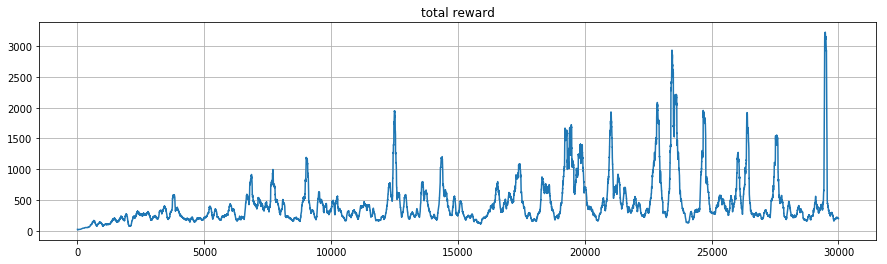

In [29]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.plot(moving_average(rewards_log))
axs.set_title('total reward')
plt.grid(True)
plt.show()

In [30]:
min(moving_average(rewards_log)[10000:])

110.36

In [31]:
max(moving_average(rewards_log)[10000:])

3224.95

### Вывод

##### В пиках получить 1000 возможно как в предыдущем методе, так и в этом

- Стабильного по скользящему среднему добиться удалось,
- если считать стабильным превышение некого значения (100, 200, в пиках 1000)


- В более общем понимании стабильности , то есть отсутствия скачков,
- добиться не удалось
- Нужно лучше подбирать параметры


- Возможно, это связано с дискретизацией, так как мы все равно теряем таким образом некое количество информации
- о системе, но по-другому никак
- Либо с несовершенством подхода, так как мы заполняем Q table
- Возможно, deep reinforcement learning решит данные проблемы, но это уже совсем другое дз...